In [1]:
import numpy as np
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
print(torch.cuda.is_available())

/home/potate/miniconda3/envs/RL_env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True


In [2]:
from environment.connectFourEnv import ConnectFourEnv
from agent.agent import ConnectFourAgent
from agent.policy import VanillaPolicyModel

In [3]:
environment = ConnectFourEnv(
    win_reward = 10,
    blank_reward = -1e-4
)

In [4]:
training_policy = VanillaPolicyModel(with_cnn = False)
training_agent = ConnectFourAgent(
    policy = training_policy,
    training = True,
    id_ = 1,
    lr = 1e-3
)

control_policy = VanillaPolicyModel(with_cnn = False)
control_agent = ConnectFourAgent(
    policy = control_policy,
    training = False,
    id_ = -1
)

In [5]:
NUM_EPOCHS = 200
BATCH_SIZE = 32

In [6]:
history = {}
for e in tqdm(range(NUM_EPOCHS)):
    history[e] = {
        'losses' : [],
        'scores' : [],
        'rewards' : []
    }
    for b in range(BATCH_SIZE):
        training_agent.no_grad()
        is_over = False
        batch_loss = None
        training_agent.reset_reward()
        environment.reset_state()
        while not is_over:
            sampling_dist = control_agent.actions_distribution(environment.state)
            action = sampling_dist.sample()
            is_over, reward, winner = control_agent.perform_action(action, environment)
            if is_over:
                if winner:
                    training_agent.reward -= reward
                    history[e]['scores'].append(-1)
                else:
                    history[e]['scores'].append(0)
            else:
                # we generate the logits from the state
                sampling_dist = training_agent.actions_distribution(environment.state)
                action = sampling_dist.sample()
                is_over, reward, winner = training_agent.perform_action(action, environment)
                training_agent.reward += reward
                if is_over:
                    history[e]['scores'].append(1 if winner else 0)
            
                weight = training_agent.reward / BATCH_SIZE
                run_loss = - sampling_dist.log_prob(action) * weight
                if batch_loss is None:
                    batch_loss = run_loss
                else:
                    batch_loss += run_loss
    
        history[e]['losses'].append(batch_loss.item())
        history[e]['rewards'].append(training_agent.reward)
        
        batch_loss.backward()
        training_agent.optimizer.step()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:32<00:00,  6.19it/s]


In [7]:
l = []
r = []
s = []
for i in range(NUM_EPOCHS):
    l.append(np.mean(history[i]['losses']))
    r.append(np.mean(history[i]['rewards']))
    s.append(np.mean(history[i]['scores']))

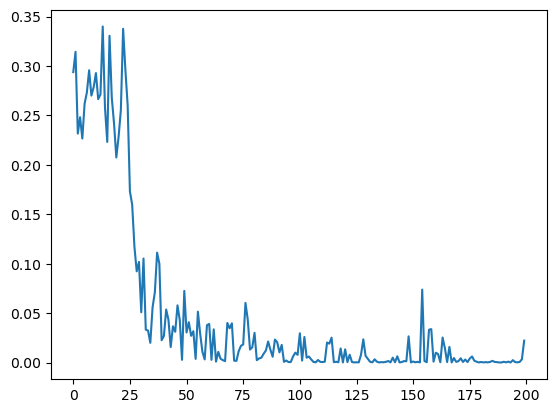

In [8]:
plt.plot(l)

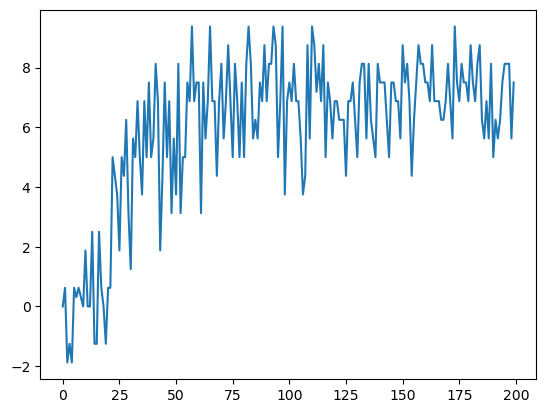

In [9]:
plt.plot(r)

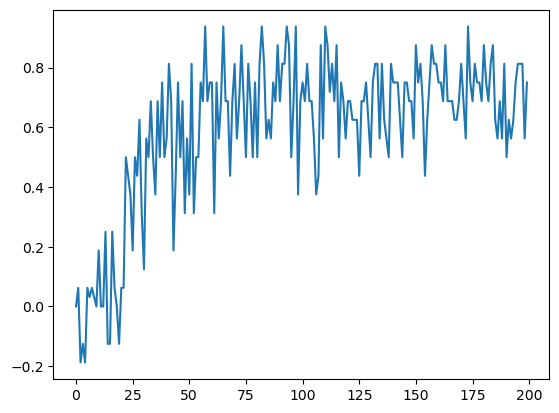

In [10]:
plt.plot(s)

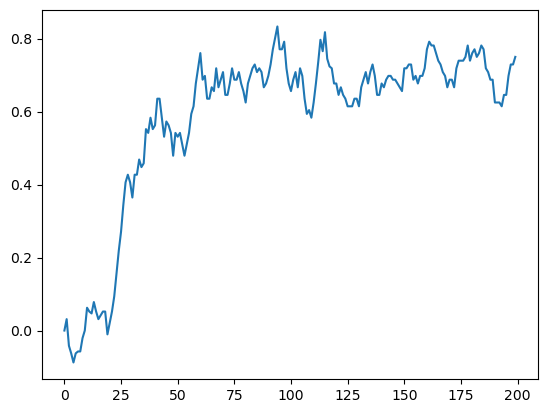

In [20]:
w = 5
mov_avg = []
for i in range(len(s)):
    m = max(0, i-w)
    M = min(len(s)-1, i+1)
    
    mov_avg.append(np.mean(s[m:M]))
    
plt.plot(mov_avg)